**Necessary imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection, linear_model, neural_network, ensemble
import xgboost
import lightgbm

**Downloading and preparing the dataset**


In [ ]:
# list containing column names, wchich includes WECs position (X1 - X16, Y1 - Y16), WECs absorbed power (P1 - P16) and target column Total power output of the
# farm (Powerall)
attributes = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12", "X13", "X14", "X15", "X16",
              "Y1", "Y2", "Y3", "Y4", "Y5", "Y6", "Y7", "Y8", "Y9", "Y10", "Y11", "Y12", "Y13", "Y14", "Y15", "Y16",
              "P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10", "P11", "P12", "P13", "P14", "P15", "P16", "Powerall"]

!wget https://archive.ics.uci.edu/static/public/494/wave+energy+converters.zip
# additional information about the dataset can be found at: https://archive.ics.uci.edu/dataset/494/wave+energy+converters


!unzip "/content/wave+energy+converters.zip"

--2023-11-10 10:34:12--  https://archive.ics.uci.edu/static/public/494/wave+energy+converters.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘wave+energy+converters.zip’

wave+energy+convert     [        <=>         ]  55.92M  35.3MB/s    in 1.6s    

2023-11-10 10:34:13 (35.3 MB/s) - ‘wave+energy+converters.zip’ saved [58633205]

Archive:  /content/wave+energy+converters.zip
   creating: WECs_DataSet/
  inflating: WECs_DataSet/Adelaide_Data.csv  
  inflating: WECs_DataSet/Perth_Data.csv  
  inflating: WECs_DataSet/Sydney_Data.csv  
  inflating: WECs_DataSet/Tasmania_Data.csv  


In [ ]:
datas = {"Adelaide" : pd.read_csv("/content/WECs_DataSet/Adelaide_Data.csv", header=0, names=attributes),
        "Perth" : pd.read_csv("/content/WECs_DataSet/Perth_Data.csv", header=0, names=attributes),
        "Sydney" : pd.read_csv("/content/WECs_DataSet/Sydney_Data.csv", header=0, names=attributes),
        "Tasmania" : pd.read_csv("/content/WECs_DataSet/Tasmania_Data.csv", header=0, names=attributes)}

**Exploratory data analysis**

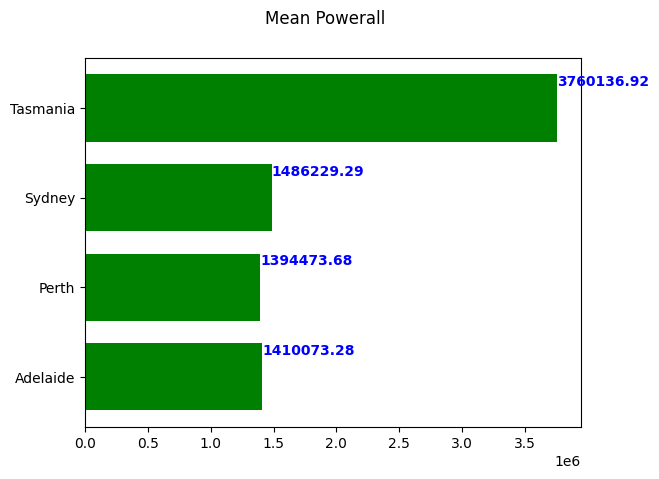

In [ ]:
y = []
cities = []
for data in datas:
  y.append(round(datas[data]['Powerall'].mean(), 2))
  cities.append(data)

fig, ax = plt.subplots()
width = 0.75
ind = np.arange(len(y))
ax.barh(ind, y, width, color = 'green')
fig.suptitle('Mean Powerall', fontsize=12)
for i, v in enumerate(y):
  ax.text(v + 3, i + .25, str(v), color = 'blue', fontweight = 'bold')
plt.yticks(np.arange(0, 4), labels=cities)
plt.show()

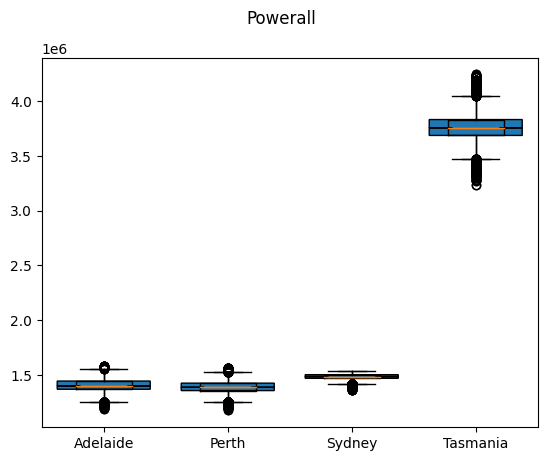

In [ ]:
y = []
for data in datas:
  y.append(datas[data]['Powerall'])

fig, ax = plt.subplots()
bp = ax.boxplot(x=y,
                patch_artist=True,
                notch=True,
                widths=0.75)

fig.suptitle('Powerall', fontsize=12)
plt.boxplot(y)
plt.xticks(np.arange(1, 5), labels=cities)
plt.show()

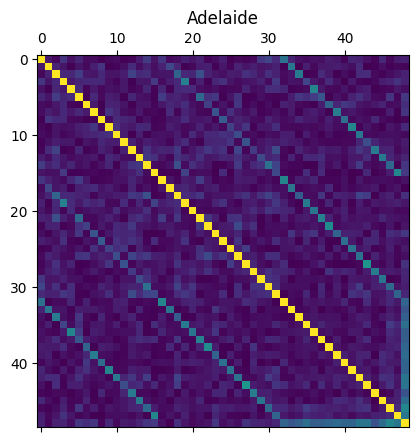

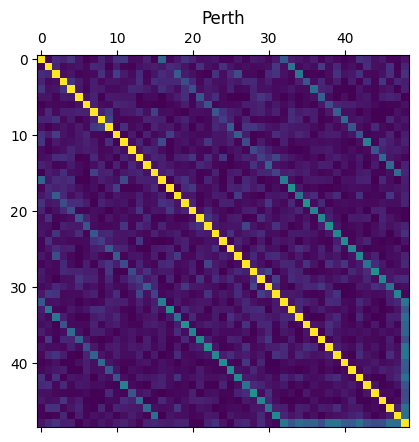

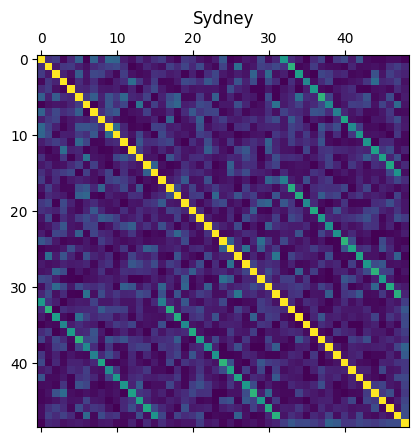

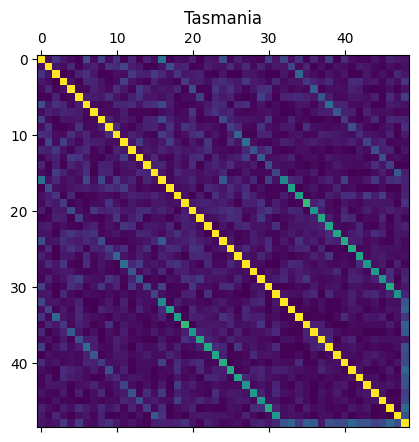

In [ ]:
for data in datas:
  corr = datas[data].corr().abs()
  plt.matshow(corr)
  plt.title(data, fontsize=12)
  plt.show()

In [ ]:
# High correlation between P1-P16 and Powerall happens, due to Powerall being a sum of P1-P16.

for data in datas:
  print(f"Sum of P1-P16 == Powerall for {data}:\n{datas[data].loc[:, 'P1':'P16'].sum(axis=1).round(3)==datas[data]['Powerall'].values}")
# Note that not all values are true. It happens due to the difference in rounding rules in Python3 and emplyed by authors.
# Pythonn3 round() documentation: https://docs.python.org/3/library/functions.html#round
# more about rounding rules allowed by the IEEE standard: https://en.wikipedia.org/w/index.php?title=IEEE_754#Rounding_rules

Sum of P1-P16 == Powerall for Adelaide:
0         True
1         True
2         True
3         True
4         True
         ...  
71993    False
71994     True
71995     True
71996    False
71997     True
Length: 71998, dtype: bool
Sum of P1-P16 == Powerall for Perth:
0        True
1        True
2        True
3        True
4        True
         ... 
71994    True
71995    True
71996    True
71997    True
71998    True
Length: 71999, dtype: bool
Sum of P1-P16 == Powerall for Sydney:
0        True
1        True
2        True
3        True
4        True
         ... 
71994    True
71995    True
71996    True
71997    True
71998    True
Length: 71999, dtype: bool
Sum of P1-P16 == Powerall for Tasmania:
0         True
1         True
2         True
3         True
4         True
         ...  
71994     True
71995     True
71996     True
71997    False
71998     True
Length: 71999, dtype: bool


Changing missing values to mean

In [ ]:
# dataset contains missing values in first 32 columns (WECs position)
# changing the missing values to mean of all values in a column may increase the performance of models

train_datas = {}
test_datas = {}

for data in datas:
  print(f"Missing values for {data}: {datas[data].eq(0).sum().sum()}")
  for (columnName, columnData) in datas[data].items():
      columnData.values[columnData.values == 0] = np.mean(columnData.values)

  x = np.array(datas[data].iloc[:, :32])
  y = np.array(datas[data]['Powerall'])
  train_datas["x_train_"+data], test_datas["x_test_"+data], train_datas["y_train_"+data], test_datas["y_test_"+data] = sklearn.model_selection.train_test_split(x, y, test_size=0.1)

Missing values for Adelaide: 98479
Missing values for Perth: 100621
Missing values for Sydney: 206430
Missing values for Tasmania: 132114


Linear Regression

In [ ]:
model = sklearn.linear_model.LinearRegression()

for data in datas:
  model.fit(train_datas['x_train_'+data], train_datas['y_train_'+data])
  predicted = model.predict(test_datas['x_test_'+data])

  error = sklearn.metrics.mean_squared_error(test_datas['y_test_'+data], predicted) ** 0.5 / np.mean(y)*100
  print(f"Error for {data}: {error.round(3)}%")

Error for Adelaide: 1.348%
Error for Perth: 1.274%
Error for Sydney: 0.546%
Error for Tasmania: 2.785%


MLPRegressor

In [ ]:
model = neural_network.MLPRegressor()

for data in datas:
  model.fit(train_datas['x_train_'+data], train_datas['y_train_'+data])
  predicted = model.predict(test_datas['x_test_'+data])

  error = sklearn.metrics.mean_squared_error(test_datas['y_test_'+data], predicted) ** 0.5 / np.mean(y)*100  # mozliwe ze do poprawy
  print(f"Error for {data}: {error.round(3)}%")
'''
Error for Adelaide: 1.972%
Error for Perth: 2.039%
Error for Sydney: 1.788%
Error for Tasmania: 5.923%'''

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Error for Adelaide: 1.965%


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Error for Perth: 2.063%


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Error for Sydney: 1.817%
Error for Tasmania: 6.074%


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


'\nError for Adelaide: 1.972%\nError for Perth: 2.039%\nError for Sydney: 1.788%\nError for Tasmania: 5.923%'

In [ ]:
'''
Error for Adelaide: 1.972%
Error for Perth: 2.039%
Error for Sydney: 1.788%
Error for Tasmania: 5.923%'''
model_grid = {'hidden_layer_sizes' : [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)],
              'tol' : [1e-3, 1e-4, 1e-5],
              #'epsilon' : [1e-7, 1e-8, 1e-9],  # only used when solver='adam' (default solver)
              'n_iter_no_change' : [int(x) for x in np.linspace(start = 5, stop = 20, num = 4)]}
model = neural_network.MLPRegressor()

for data in datas:
  model_random = model_selection.RandomizedSearchCV(estimator=model, param_distributions=model_grid, n_iter=30, cv=3, verbose=3, n_jobs=2)
  model_random.fit(train_datas['x_train_'+data], train_datas['y_train_'+data])
  predicted = model_random.predict(test_datas['x_test_'+data])

  error = sklearn.metrics.mean_squared_error(test_datas['y_test_'+data], predicted) ** 0.5 / np.mean(y)*100
  print(f"Error for {data}: {error.round(3)}%")

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Error for Adelaide: 2.775%
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Error for Perth: 2.585%
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Error for Sydney: 2.35%
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Error for Tasmania: 8.072%


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


XGBRegressor

In [ ]:
model = xgboost.XGBRegressor()

for data in datas:
  model.fit(train_datas['x_train_'+data], train_datas['y_train_'+data])
  predicted = model.predict(test_datas['x_test_'+data])

  error = sklearn.metrics.mean_squared_error(test_datas['y_test_'+data], predicted) ** 0.5 / np.mean(y)*100  # mozliwe ze do poprawy
  print(f"Error for {data}: {error.round(3)}%")

Error for Adelaide: 0.556%
Error for Perth: 0.569%
Error for Sydney: 0.242%
Error for Tasmania: 1.469%


XGBRegressor with hyperparameter tuning

In [ ]:
model_grid = {'booster' : ['gbtree', 'gblinear'],
              'max_depth' : [int(x) for x in np.linspace(start = 3, stop = 12, num = 4)],
              'n_estimators' : [int(x) for x in np.linspace(start = 50, stop = 150, num = 5)],
              'num_parallel_tree' : [x for x in range (1, 3)],
              'objective' : ['reg:squarederror']}
# yooo progress!
model = xgboost.XGBRegressor()

for data in datas:
  model_random = model_selection.RandomizedSearchCV(estimator=model, param_distributions=model_grid, n_iter=10, cv=3, verbose=3, n_jobs=2)
  model_random.fit(train_datas['x_train_'+data], train_datas['y_train_'+data])
  predicted = model_random.predict(test_datas['x_test_'+data])

  error = sklearn.metrics.mean_squared_error(test_datas['y_test_'+data], predicted) ** 0.5 / np.mean(y)*100  # mozliwe ze do poprawy
  print(f"Error for {data}: {error.round(3)}%")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Error for Adelaide: 0.542%
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Error for Perth: 0.595%
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Error for Sydney: 0.202%
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Error for Tasmania: 1.469%


In [ ]:
model_grid = {'booster' : ['gbtree', 'gblinear'],
              'max_depth' : [int(x) for x in np.linspace(start = 3, stop = 12, num = 4)],
              'n_estimators' : [int(x) for x in np.linspace(start = 50, stop = 150, num = 5)],
              'num_parallel_tree' : [x for x in range (1, 3)],
              'objective' : ['reg:squarederror']}
model = xgboost.XGBRegressor()

for data in datas:
  model_search = model_selection.GridSearchCV(estimator=model, param_grid=model_grid, cv=3, verbose=3, n_jobs=2)
  model_search.fit(train_datas['x_train_'+data], train_datas['y_train_'+data])
  predicted = model_search.predict(test_datas['x_test_'+data])

  error = sklearn.metrics.mean_squared_error(test_datas['y_test_'+data], predicted) ** 0.5 / np.mean(y)*100  # mozliwe ze do poprawy
  print(f"Error for {data}: {error.round(3)}%")

Fitting 3 folds for each of 80 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Error for Adelaide: 0.542%
Fitting 3 folds for each of 80 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Error for Perth: 0.554%
Fitting 3 folds for each of 80 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Error for Sydney: 0.183%
Fitting 3 folds for each of 80 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Error for Tasmania: 1.434%


'\nError for Adelaide: 0.532%\nError for Perth: 0.539%\nError for Sydney: 0.196%\nError for Tasmania: 1.446%\n'

LGBMRegressor

In [ ]:
model = lightgbm.LGBMRegressor(force_col_wise='true')

for data in datas:
  model.fit(train_datas['x_train_'+data], train_datas['y_train_'+data])
  predicted = model.predict(test_datas['x_test_'+data])

  error = sklearn.metrics.mean_squared_error(test_datas['y_test_'+data], predicted) ** 0.5 / np.mean(y)*100  # mozliwe ze do poprawy
  print(f"Error for {data}: {error.round(3)}%")

[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 64798, number of used features: 32
[LightGBM] [Info] Start training from score 1410117.153512
Error for Adelaide: 0.607%
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 64799, number of used features: 32
[LightGBM] [Info] Start training from score 1394383.353794
Error for Perth: 0.6%
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 64799, number of used features: 32
[LightGBM] [Info] Start training from score 1486279.833084
Error for Sydney: 0.273%
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 64799, number of used features: 32
[LightGBM] [Info] Start training from score 3760039.663170
Error for Tasmania: 1.533%


LGBMRegressor with hyperparameter tuning

In [ ]:
model_grid = {'boosting': ['gbdt', 'dart'],
              'num_leaves': [int(x) for x in np.linspace(start = 25, stop = 45, num = 5)],
              'n_estimators' : [int(x) for x in np.linspace(start = 50, stop = 150, num = 5)],
              'objective': ['regression'],
              'force_col_wise' : ['true']}
model = lightgbm.LGBMRegressor()

for data in datas:
  model_random = model_selection.GridSearchCV(estimator=model, param_grid=model_grid, cv=3, verbose=3, n_jobs=2)
  model_random.fit(train_datas['x_train_'+data], train_datas['y_train_'+data])
  predicted = model_random.predict(test_datas['x_test_'+data])

  error = sklearn.metrics.mean_squared_error(test_datas['y_test_'+data], predicted) ** 0.5 / np.mean(y)*100  # mozliwe ze do poprawy
  print(f"Error for {data}: {error.round(3)}%")
'''
Error for Adelaide: 0.542%
Error for Perth: 0.554%
Error for Sydney: 0.183%
Error for Tasmania: 1.434%
'''

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 64798, number of used features: 32
[LightGBM] [Info] Start training from score 1410117.153512
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Error for Adelaide: 0.552%
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 64799, number of used features:

RandomForestRegressor

In [ ]:
model = ensemble.RandomForestRegressor()

for data in datas:
  model.fit(train_datas['x_train_'+data], train_datas['y_train_'+data])
  predicted = model.predict(test_datas['x_test_'+data])

  error = sklearn.metrics.mean_squared_error(test_datas['y_test_'+data], predicted) ** 0.5 / np.mean(y)*100  # mozliwe ze do poprawy
  print(f"Error for {data}: {error.round(3)}%")

Error for Adelaide: 0.68%
Error for Perth: 0.656%
Error for Sydney: 0.23%
Error for Tasmania: 1.644%


RandomForestRegressor with hyperparameter tuning

In [ ]:
model_grid = {'n_estimators' : [int(x) for x in np.linspace(start = 50, stop = 150, num = 5)],
              'criterion' : ['squared_error'],
              'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 8, num = 4)],
              'min_samples_leaf': [1, 2, 4]}
model = ensemble.RandomForestRegressor()

for data in datas:
  model_random = model_selection.RandomizedSearchCV(estimator=model, param_distributions=model_grid, n_iter=10, cv=3, verbose=3, n_jobs=2)
  model_random.fit(train_datas['x_train_'+data], train_datas['y_train_'+data])
  predicted = model_random.predict(test_datas['x_test_'+data])

  error = sklearn.metrics.mean_squared_error(test_datas['y_test_'+data], predicted) ** 0.5 / np.mean(y)*100  # mozliwe ze do poprawy
  print(f"Error for {data}: {error.round(3)}%")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Error for Adelaide: 0.669%
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Error for Perth: 0.646%
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Error for Sydney: 0.229%
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Error for Tasmania: 1.674%
